In [716]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import MultiGrid

from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector


import random

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [717]:
class CleaningAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.type = 3
    def step(self):
        
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)

        empty_cells = [cell for cell in possible_steps if self.model.grid.is_cell_empty(cell)] 

        if (empty_cells) :

            current_dirty_value = self.model.get_dirty_value(self.pos[0],self.pos[1] )
            if current_dirty_value == 1:
                self.model.clean(self.pos[0],self.pos[1])
                chosen_cell = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, chosen_cell)
            else:
                chosen_cell = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, chosen_cell)


In [718]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height), dtype=int)
    
    for (content, (x, y)) in model.grid.coord_iter():

        if content:
            grid[x][y] = 1   # Cleaning agent
        else:
            grid[x][y] = 0  # Empty cell

    # Include representation of self.model.dirty attribute
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            if model.get_dirty_value(x, y) == 1:
                grid[x][y] = 2  # Dirty cell (brown)

    print(grid)  # Add this line to print the grid values
    return grid


In [719]:
class CleaningModel(Model):
    def __init__ (self, width, height, num_agents, dirty_percent = 0.9):
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        self.dirty = np.zeros((width, height))

        dirty_cells = int (width*height* dirty_percent)
        print(dirty_cells)

        id = 0
        
        for i in range(1, (num_agents + 1)):
                cleaner = CleaningAgent(id, self)
                self.grid.place_agent(cleaner, (1, 1))
                self.schedule.add(cleaner)
                id = id + 1

        for i in range(1, dirty_cells+1):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)):
                self.dirty[x][y] = 1

    def get_dirty_value(self,x,y):
        return self.dirty[x][y] 

    def clean(self, x,y ):
        self.dirty[x][y] = 0
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()            


In [720]:
WIDTH = 100
HEIGHT = 100
DIRTY_PERCENTAGE = 0.9  
NUM_AGENTS = 2
# Definimos el número máximo de generaciones a correr
MAX_STEPS = 100

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = CleaningModel(WIDTH, HEIGHT, NUM_AGENTS, DIRTY_PERCENTAGE)

initial_grid = get_grid(model)
print(initial_grid)

for i in range(MAX_STEPS):
    model.step()
# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

9000
[[2 2 0 ... 0 0 2]
 [0 1 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 2 0 ... 0 0 2]
 [0 1 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 2 0 ... 0 0 2]
 [0 1 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 2 1 ... 0 0 2]
 [1 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 2 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 0 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[0 1 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[1 0 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[0 1 0 ... 0 0 2]
 [0 0 2 ... 2 2 

In [721]:
all_grid = model.datacollector.get_model_vars_dataframe()

[0 1 2]
[[2 2 0 ... 0 0 2]
 [0 1 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]


C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\2271854867.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=2)
C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\2271854867.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(np.unique(all_grid.iloc[0][0]))
C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\2271854867.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `s

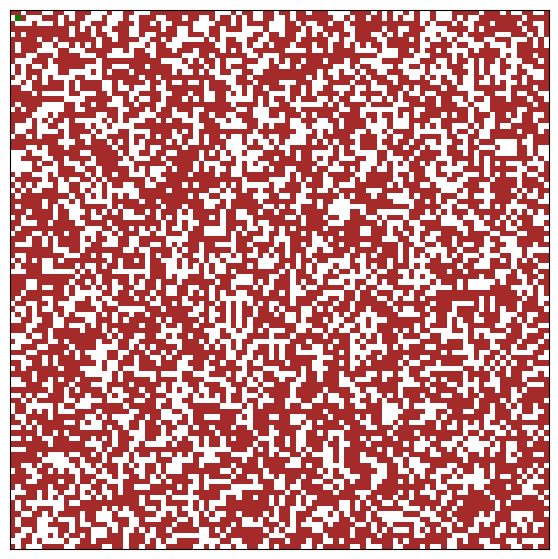

In [722]:
fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])

# Define a colormap for visualization
cmap = plt.cm.colors.ListedColormap(['white', 'green', 'brown'])

patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=2)

print(np.unique(all_grid.iloc[0][0]))

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    patch.set_clim(vmin=0, vmax=2)  # Update the color limits for each frame
    print(all_grid.iloc[i][0]) 

anim = animation.FuncAnimation(fig, animate, frames=MAX_STEPS)

In [723]:
anim

C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\2271854867.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])
C:\Users\Charlie\AppData\Local\Temp\ipykernel_11216\2271854867.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(all_grid.iloc[i][0])


[[2 2 0 ... 0 0 2]
 [0 1 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 2 0 ... 0 0 2]
 [0 1 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 2 1 ... 0 0 2]
 [1 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 2 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[2 0 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[0 1 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[1 0 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[0 1 0 ... 0 0 2]
 [0 0 2 ... 2 2 2]
 [2 0 0 ... 0 0 2]
 ...
 [2 0 0 ... 2 2 2]
 [0 0 2 ... 0 0 2]
 [2 0 2 ... 0 2 2]]
[[0 0 0 ... 0 0 2]
 [1 0 2 ... 2 2 2]
 [